In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

In [ ]:
# Ensure TensorFlow uses memory efficiently
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
BASE_PATH = "/content/drive/MyDrive/EuroSat/EuroSAT_RGB"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
VALID_SIZE = 0.2

In [ ]:
# Create DataFrame with image paths and labels
def create_dataframe(base_path):
    file_list = [(os.path.join(root, file), os.path.basename(root))
                 for root, _, files in os.walk(base_path) for file in files]
    return pd.DataFrame(file_list, columns=['image_path', 'label'])

In [ ]:
# Load dataset
DATA_DF = create_dataframe(BASE_PATH)
DATA_DF['label'] = DATA_DF['label'].astype('category')
DATA_DF['label_code'] = DATA_DF['label'].cat.codes

In [ ]:
# Debug: Class distribution
print("\n🔍 Class Distribution Before Splitting:\n", DATA_DF['label'].value_counts())


🔍 Class Distribution Before Splitting:
 label
Residential             3010
AnnualCrop              3000
Forest                  3000
HerbaceousVegetation    3000
SeaLake                 3000
Highway                 2500
PermanentCrop           2500
Industrial              2500
River                   2500
Pasture                 2000
Name: count, dtype: int64


In [ ]:
# Train-validation split
TRAIN_DF, VALID_DF = train_test_split(DATA_DF, test_size=VALID_SIZE, stratify=DATA_DF['label_code'], random_state=48)
print("\n🔍 Train Distribution:\n", TRAIN_DF['label'].value_counts())
print("\n🔍 Validation Distribution:\n", VALID_DF['label'].value_counts())


🔍 Train Distribution:
 label
Residential             2408
AnnualCrop              2400
Forest                  2400
HerbaceousVegetation    2400
SeaLake                 2400
Highway                 2000
PermanentCrop           2000
Industrial              2000
River                   2000
Pasture                 1600
Name: count, dtype: int64

🔍 Validation Distribution:
 label
Residential             602
AnnualCrop              600
Forest                  600
HerbaceousVegetation    600
SeaLake                 600
Highway                 500
PermanentCrop           500
Industrial              500
River                   500
Pasture                 400
Name: count, dtype: int64


In [ ]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(TRAIN_DF['label_code']), y=TRAIN_DF['label_code'])
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

In [ ]:
# Preprocessing function
def process_path(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize
    img = data_augmentation(img)
    return img, label

In [ ]:
# Create dataset
def create_dataset(df, training=True):
    dataset = tf.data.Dataset.from_tensor_slices((df['image_path'].values, df['label_code'].values))
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) if training else dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = create_dataset(TRAIN_DF, training=True)
valid_ds = create_dataset(VALID_DF, training=False)

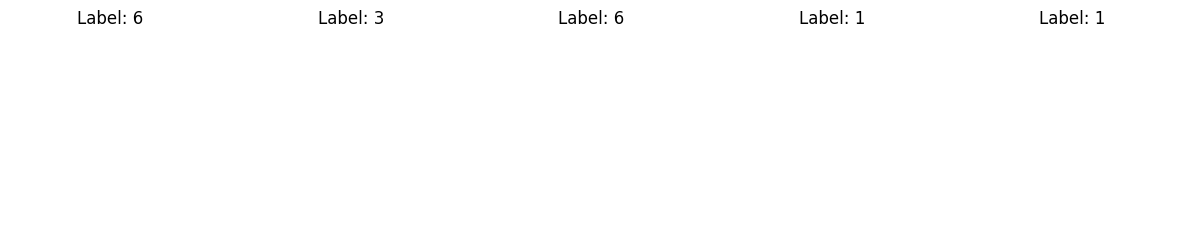

In [ ]:
# Debug: Check images
def check_images(dataset, num_samples=5):
    for images, labels in dataset.take(1):
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
        for i in range(num_samples):
            axes[i].imshow(images[i].numpy())
            axes[i].set_title(f"Label: {labels[i].numpy()}")
            axes[i].axis('off')
        plt.show()
check_images(train_ds)

In [ ]:
# Model Definition
base_model = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model initially

In [ ]:
# Freeze only first 100 layers for better learning
for layer in base_model.layers[:100]:
    layer.trainable = False

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(DATA_DF['label_code'].unique()), activation='softmax')
])

In [ ]:
# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train Model
model.fit(train_ds, validation_data=valid_ds, epochs=20, class_weight=class_weights_dict)

Epoch 1/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 1547s 2s/step - accuracy: 0.6805 - loss: 1.0955 - val_accuracy: 0.9115 - val_loss: 0.2851
Epoch 2/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 383s 481ms/step - accuracy: 0.8942 - loss: 0.3400 - val_accuracy: 0.9311 - val_loss: 0.2200
Epoch 3/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 379s 477ms/step - accuracy: 0.9101 - loss: 0.2797 - val_accuracy: 0.9376 - val_loss: 0.1942
Epoch 4/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 399s 503ms/step - accuracy: 0.9220 - loss: 0.2476 - val_accuracy: 0.9447 - val_loss: 0.1801
Epoch 5/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 381s 502ms/step - accuracy: 0.9224 - loss: 0.2389 - val_accuracy: 0.9415 - val_loss: 0.1769
Epoch 6/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 367s 479ms/step - accuracy: 0.9284 - loss: 0.2161 - val_accuracy: 0.9443 - val_loss: 0.1632
Epoch 7/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 398s 504ms/step - accuracy: 0.9325 - loss: 0.2075 - val_accuracy: 0.9498 - val_loss: 0.1550
Epoch 8/20
676/676 ━━━━━━━━━━━━━━━━━━━━ 382s 503ms/step - accuracy: 0.9368 - l

In [ ]:
# Fine-tuning: Unfreeze some layers
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, validation_data=valid_ds, epochs=10, class_weight=class_weights_dict)

Epoch 1/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 413s 539ms/step - accuracy: 0.8316 - loss: 0.5301 - val_accuracy: 0.9347 - val_loss: 0.2079
Epoch 2/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 399s 503ms/step - accuracy: 0.9081 - loss: 0.2892 - val_accuracy: 0.9441 - val_loss: 0.1600
Epoch 3/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 399s 528ms/step - accuracy: 0.9204 - loss: 0.2495 - val_accuracy: 0.9491 - val_loss: 0.1434
Epoch 4/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 369s 510ms/step - accuracy: 0.9282 - loss: 0.2144 - val_accuracy: 0.9524 - val_loss: 0.1332
Epoch 5/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 392s 524ms/step - accuracy: 0.9344 - loss: 0.1922 - val_accuracy: 0.9574 - val_loss: 0.1330
Epoch 6/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 367s 501ms/step - accuracy: 0.9357 - loss: 0.1972 - val_accuracy: 0.9598 - val_loss: 0.1209
Epoch 7/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 397s 526ms/step - accuracy: 0.9402 - loss: 0.1816 - val_accuracy: 0.9608 - val_loss: 0.1165
Epoch 8/10
676/676 ━━━━━━━━━━━━━━━━━━━━ 381s 523ms/step - accuracy: 0.9440 -

In [ ]:
# Save Model
model.save("best_model.keras")

In [ ]:
def evaluate_model(model, dataset):
    y_true, y_pred = [], []
    for images, labels in dataset:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print("\n🔍 Classification Report:\n", classification_report(y_true, y_pred))

In [ ]:
evaluate_model(model, valid_ds)